In [ ]:
# Bert implementation derived from https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/
# Passive aggressive classifier derived from https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/

In [1]:
!pip install transformers==3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch.nn as nn
from tqdm import tqdm 
import torch
from transformers import BertTokenizerFast, AdamW, BertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

C:\Users\harry\anaconda3\envs\projectEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cpu")

In [42]:
fakeData = pd.read_csv('archive\Fake.csv')
fakeData['label'] = 0

realData = pd.read_csv('archive\True.csv')
realData['label'] = 1

data = pd.concat([fakeData, realData], ignore_index=True)
df = data[['title', 'label']]

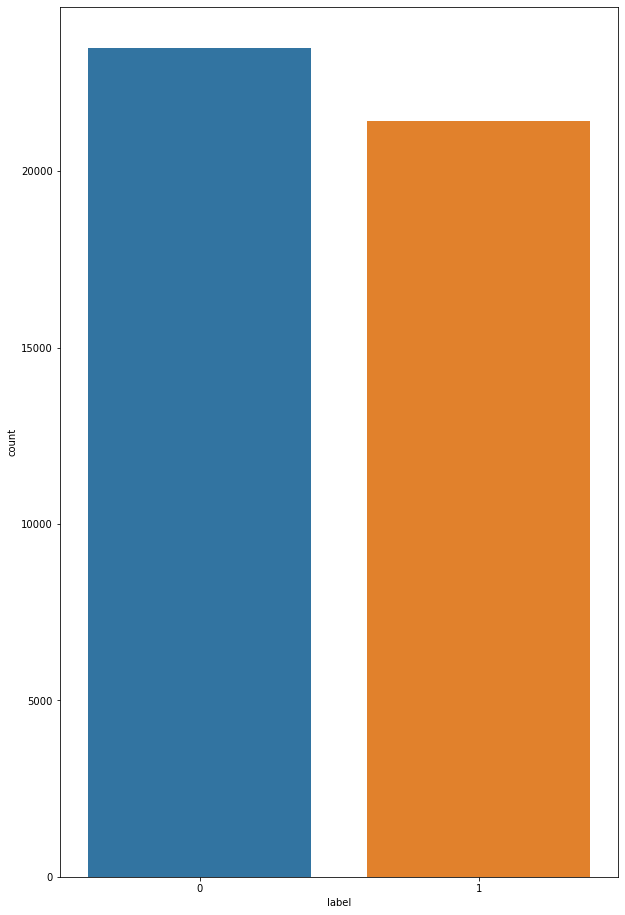

In [5]:
Balance_plt = plt.figure(figsize=(10,16))

sns.countplot(x="label", data=df);

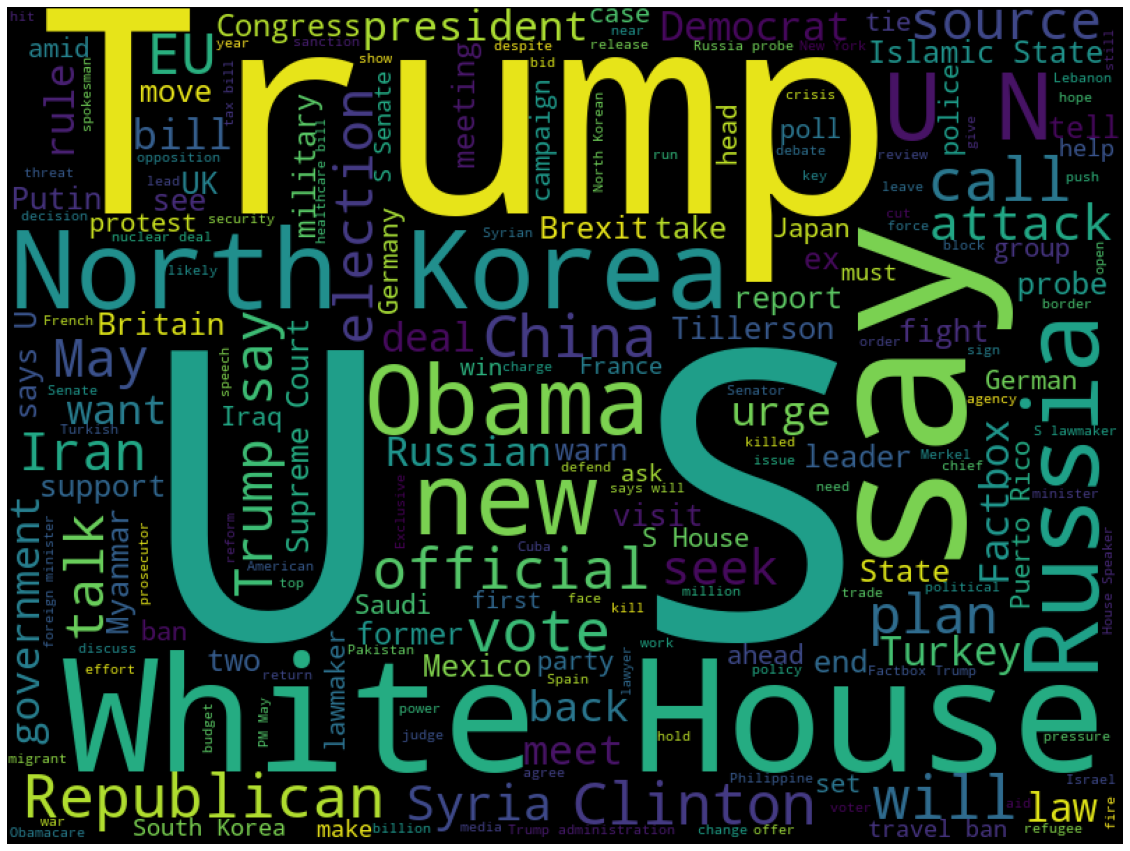

In [43]:
wordcloud = WordCloud( background_color='black', width=800, height=600)

text_cloud = wordcloud.generate(' '.join(df[df.label == 1]['title']))

plt.figure(figsize=(20,30))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

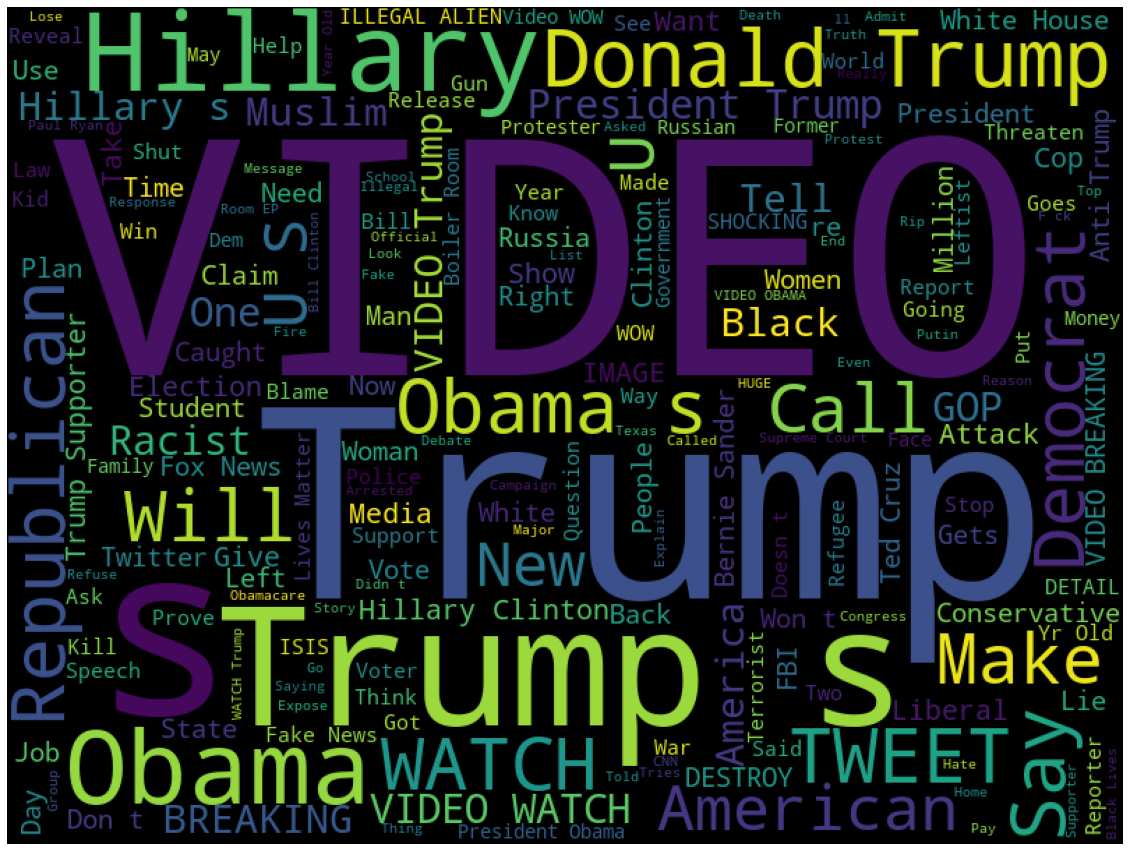

In [44]:
wordcloud = WordCloud( background_color='black', width=800, height=600)

text_cloud = wordcloud.generate(' '.join(df[df.label == 0]['title']))

plt.figure(figsize=(20,30))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

In [45]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['title'], df['label'], random_state=150, test_size=0.3, stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=150, test_size=0.5, stratify=temp_labels)

In [9]:
#import BERT model
bert = BertModel.from_pretrained('bert-base-uncased')

#BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [10]:
#training settokenize and encode sequences
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

#validation set tokenize and encode sequences
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

#test set tokenize and encode sequences
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [46]:
#convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [47]:
batch_size = 32

#wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

#training sampler
train_sampler = RandomSampler(train_data)

#dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

#training sampler
val_sampler = SequentialSampler(val_data)

#dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [48]:
for param in bert.parameters():
    param.requires_grad = False

In [14]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

        super(BERT_Arch, self).__init__()

        self.bert = bert 

        self.dropout = nn.Dropout(0.1)

        #relu activation function
        self.relu =  nn.ReLU()
        
        #layer 1
        self.fc1 = nn.Linear(768,512)

        #layer 2
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [49]:
#input the model into the architecture
model = BERT_Arch(bert)

# push the model to the device
model = model.to(device)

In [50]:
#optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

In [51]:
#compute the class weights
class_weights = compute_class_weight(class_weight = 'balanced',classes = np.unique(train_labels),y =  train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.95607204 1.04815902]


In [18]:
#converts to tensor
weights= torch.tensor(class_weights,dtype=torch.float)

#push to device
weights = weights.to(device)

#loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

In [19]:
def train():
  
    model.train()

    total_loss, total_accuracy = 0, 0
    
    total_preds=[]

    with tqdm(train_dataloader, position=0, leave=True) as loop:
        for step,batch in enumerate(loop):

            #push the batch to device
            batch = [r.to(device) for r in batch]

            sent_id, mask, labels = batch

            #clear gradients 
            model.zero_grad()        

            #get predictions
            preds = model(sent_id, mask)

            #calculate loss
            loss = cross_entropy(preds, labels)

            total_loss = total_loss + loss.item()

            #backward pass to calculate the gradients
            loss.backward()

            #clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            #update parameters
            optimizer.step()

            #move model predictions to cpu used if running on a gpu
            preds=preds.detach().cpu().numpy()

            #append the model predictions
            total_preds.append(preds)

            loop.set_postfix(loss=loss.item())
            loop.update()

    #compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [20]:
def evaluate():

    print("\nEvaluating...")

    #deactivate dropout layers
    model.eval()
    
    total_loss, total_accuracy = 0, 0

    total_preds = []
    
    with tqdm(val_dataloader, position=0, leave=True) as loop:
        for step,batch in enumerate(loop):

            # push the batch to deivce
            batch = [t.to(device) for t in batch]

            sent_id, mask, labels = batch
            
            loop.update()
            
            #deactivate autograd
            with torch.no_grad():

                    #model predictions
                    preds = model(sent_id, mask)

                    #compute the loss between actual and predicted values
                    loss = cross_entropy(preds,labels)

                    total_loss = total_loss + loss.item()

                    preds = preds.detach().cpu().numpy()

                    total_preds.append(preds)
                    

    #compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    #reshape the predictions
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [54]:
# number of training epochs
epochs = 5

#set initial loss
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    train_loss, _ = train()
    
    valid_loss, _ = evaluate()
    
    #best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'new_BERT_saved_weights_text_2.pt')
    
    #append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5


100%|██████████| 983/983 [30:03<00:00,  1.83s/it, loss=0.716]



Evaluating...


100%|██████████| 211/211 [05:26<00:00,  1.55s/it]



Training Loss: 0.694
Validation Loss: 0.694

 Epoch 2 / 5


100%|██████████| 983/983 [30:05<00:00,  1.84s/it, loss=0.7]  



Evaluating...


100%|██████████| 211/211 [05:25<00:00,  1.54s/it]



Training Loss: 0.694
Validation Loss: 0.693

 Epoch 3 / 5


100%|██████████| 983/983 [30:04<00:00,  1.84s/it, loss=0.691]



Evaluating...


100%|██████████| 211/211 [05:24<00:00,  1.54s/it]



Training Loss: 0.694
Validation Loss: 0.693

 Epoch 4 / 5


100%|██████████| 983/983 [30:05<00:00,  1.84s/it, loss=0.687]



Evaluating...


100%|██████████| 211/211 [05:22<00:00,  1.53s/it]



Training Loss: 0.694
Validation Loss: 0.694

 Epoch 5 / 5


100%|██████████| 983/983 [30:13<00:00,  1.84s/it, loss=0.727]



Evaluating...


100%|██████████| 211/211 [05:25<00:00,  1.54s/it]


Training Loss: 0.694
Validation Loss: 0.694


In [65]:
#load weights
path = 'new_BERT_saved_weights_text_2.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [66]:
#produce the predictions
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [67]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.53      0.83      0.65      3523
           1       0.52      0.20      0.28      3212

    accuracy                           0.53      6735
   macro avg       0.52      0.51      0.47      6735
weighted avg       0.52      0.53      0.47      6735



In [60]:
#vectorize the words for the passive aggressive classifier
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)

tfidf_train=tfidf_vectorizer.fit_transform(train_text)
tfidf_test=tfidf_vectorizer.transform(test_text)

In [61]:
#train the passive aggressive classifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,train_labels)

#produce the predictions
y_pred=pac.predict(tfidf_test)
print(classification_report(test_labels,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3523
           1       0.95      0.94      0.94      3212

    accuracy                           0.95      6735
   macro avg       0.95      0.95      0.95      6735
weighted avg       0.95      0.95      0.95      6735



In [36]:
sentence = "this is a sentence"
sentence2 = "This is another sentence"

#sentence_tokens = tfidf_vectorizer.fit_transform(sentence)
#sentence2_tokens = tfidf_vectorizer.fit_transform(sentence2)

sentence_tokens = tokenizer.batch_encode_plus(
    [sentence],
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

sentence2_tokens = tokenizer.batch_encode_plus(
    [sentence2],
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

print(sentence_tokens)
print(sentence2_tokens)

{'input_ids': [[101, 2023, 2003, 1037, 6251, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}
{'input_ids': [[101, 2023, 2003, 2178, 6251, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}
